# Full pipeline

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import logging

<IPython.core.display.Javascript object>

In [3]:
import numpy as np

<IPython.core.display.Javascript object>

In [4]:
import plotly.graph_objects as go

<IPython.core.display.Javascript object>

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

In [6]:
from comms_helper.data.scraping import (
    scrape_tweets,
    scraped_tweets_to_df,
)
from comms_helper.preprocessing.handle_extraction import extract_handles

<IPython.core.display.Javascript object>

In [7]:
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 9)
plt.rcParams["figure.dpi"] = 90

<IPython.core.display.Javascript object>

## Params

In [8]:
RANDOM_STATE = 42

<IPython.core.display.Javascript object>

In [9]:
SEARCH_TERM = "Robert Hazell"

TESTING = False

N_MAX = 20 if TESTING else 5000

<IPython.core.display.Javascript object>

## Logger

In [10]:
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s [%(name)s] %(levelname)-8s %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

<IPython.core.display.Javascript object>

In [11]:
logging.getLogger("snscrape").setLevel(
    logging.WARNING
)  # mute noisy logging from snscrape

<IPython.core.display.Javascript object>

## Scrape data

In [12]:
tweets_lst = scrape_tweets(SEARCH_TERM, N_MAX)

2022-05-24 08:07:47,314 [root] INFO     [comms_helper.data.scraping] Scraping the first 5000 tweets for search 'Robert Hazell'...
 24%|███████████████████████▌                                                                          | 1205/5000 [00:32<01:40, 37.61it/s]
2022-05-24 08:08:19,358 [root] INFO     [comms_helper.data.scraping] Scraped 1,205 tweets


<IPython.core.display.Javascript object>

In [13]:
df = scraped_tweets_to_df(tweets_lst)

/usr/local/lib/python3.8/site-packages/comms_helper/data/scraping.py:73: FutureWarning: username is deprecated, use user.username instead
  tweet_dict["username"] = [tweet.username for tweet in tweets_list]


<IPython.core.display.Javascript object>

In [14]:
df.head()

,url,date,content,id,username
0,https://twitter.com/BYMYong/status/15276305194...,2022-05-20 12:41:12+00:00,"@StephenRW01 Yes, exactly! Robert Hazell and I...",1527630519470637056,BYMYong
1,https://twitter.com/BYMYong/status/15268643192...,2022-05-18 09:56:36+00:00,Great thread. From a book Robert Hazell and I ...,1526864319299960832,BYMYong
2,https://twitter.com/ConUnit_UCL/status/1526609...,2022-05-17 17:04:19+00:00,This seminar will look back on the constitutio...,1526609569983909890,ConUnit_UCL
3,https://twitter.com/ConUnit_UCL/status/1526180...,2022-05-16 12:39:26+00:00,⏰Time to take stock...\n\nJoin us tomorrow to ...,1526180521704935425,ConUnit_UCL
4,https://twitter.com/RobBurl/status/15240727736...,2022-05-10 17:03:59+00:00,Coming up at 6pm on @lbc Tonight with Andrew M...,1524072773643116545,RobBurl


<IPython.core.display.Javascript object>

In [15]:
df["date"].min()

Timestamp('2008-08-04 17:36:37+0000', tz='UTC')

<IPython.core.display.Javascript object>

In [16]:
df = df.set_index("id")

<IPython.core.display.Javascript object>

## Preprocessing

### Extract handles

In [17]:
extracted_handles = extract_handles(df["content"])

<IPython.core.display.Javascript object>

## Create graph

### Create

In [98]:
df_mentions = (
    df.join(extracted_handles.to_frame("handle_ref"))
    .rename(columns={"username": "handle"})
    .dropna()
)[["handle", "handle_ref", "date"]].reset_index()

<IPython.core.display.Javascript object>

In [99]:
df_edges = (
    (
        df_mentions.reset_index()
        .groupby(["handle", "handle_ref"])
        .agg({"id": lambda x: list(x), "index": "count"})
    )
    .reset_index()
    .rename(columns={"index": "n_links"})
)

<IPython.core.display.Javascript object>

In [100]:
df_edges["n_links_inv"] = 1 / df_edges["n_links"]

<IPython.core.display.Javascript object>

In [101]:
include_files = True

<IPython.core.display.Javascript object>

In [102]:
edge_attr_list = ["n_links", "n_links_inv"]
if include_files:
    edge_attr_list += ["id"]
cols = ["handle", "handle_ref"] + edge_attr_list

<IPython.core.display.Javascript object>

In [103]:
from comms_helper.analysis.network import MyGraph

<IPython.core.display.Javascript object>

In [104]:
myg = MyGraph.TupleList(
    df_edges[cols].itertuples(index=False),
    edge_attrs=edge_attr_list,
)

myg.get_metrics()

myg.get_info_table_edges()

myg.info_table.sort_values("betweenness", ascending=False).head()

2022-05-24 08:27:52,953 [root] INFO     [comms_helper.data.scraping] Getting centralities...
2022-05-24 08:27:53,021 [root] INFO     [comms_helper.data.scraping] Got centralities
2022-05-24 08:27:53,022 [root] INFO     [comms_helper.data.scraping] Getting communities...
2022-05-24 08:27:53,024 [root] INFO     [comms_helper.data.scraping] Got communities
2022-05-24 08:27:53,024 [root] INFO     [comms_helper.data.scraping] Getting entity info table...
2022-05-24 08:27:53,027 [root] INFO     [comms_helper.data.scraping] Got entity info table


,betweenness,degree,eigenvector,closeness,community,name
1,113422.566667,252,1.000000,0.750200,0,ConUnit_UCL
577,15148.166667,12,0.042934,0.576713,17,pfdoran
204,10884.833333,39,0.064003,0.731402,22,uclspp
146,9478.000000,25,0.097888,0.697123,21,OxfordFLJS
20,9098.500000,11,0.011049,0.461697,4,ucl


<IPython.core.display.Javascript object>

### Prune

In [176]:
# g_pruned = myg.prune_nodes(cutoff=2, update_info=True)
# g_pruned.delete_single_nodes()
# g_pruned.get_metrics()

# g_pruned.get_info_table_edges()

# g_pruned.info_table.sort_values("betweenness", ascending=False).head()

2022-05-24 09:35:44,032 [root] INFO     [comms_helper.data.scraping] Getting centralities...
2022-05-24 09:35:44,047 [root] INFO     [comms_helper.data.scraping] Got centralities
2022-05-24 09:35:44,048 [root] INFO     [comms_helper.data.scraping] Getting communities...
2022-05-24 09:35:44,059 [root] INFO     [comms_helper.data.scraping] Got communities
2022-05-24 09:35:44,060 [root] INFO     [comms_helper.data.scraping] Getting entity info table...
2022-05-24 09:35:44,070 [root] INFO     [comms_helper.data.scraping] Got entity info table
2022-05-24 09:35:44,071 [root] INFO     [comms_helper.data.scraping] Getting centralities...
2022-05-24 09:35:44,078 [root] INFO     [comms_helper.data.scraping] Got centralities
2022-05-24 09:35:44,079 [root] INFO     [comms_helper.data.scraping] Getting communities...
2022-05-24 09:35:44,083 [root] INFO     [comms_helper.data.scraping] Got communities
2022-05-24 09:35:44,083 [root] INFO     [comms_helper.data.scraping] Getting entity info table...
2

,betweenness,degree,eigenvector,closeness,community,name
0,14376.466667,134,1.000000,0.973346,0,ConUnit_UCL
177,2527.500000,11,0.066217,0.712976,4,pfdoran
14,1101.500000,7,0.065623,0.847686,5,BBCWestminHour
10,1055.500000,8,0.023605,0.544520,4,ucl
41,1019.500000,11,0.052887,0.915306,8,CommonsPACAC


<IPython.core.display.Javascript object>

## Visualise

### Wordcloud

In [25]:
from comms_helper.visualisation.wordclouds import ser_to_fig_wordcloud, ser_to_wordcloud

<IPython.core.display.Javascript object>

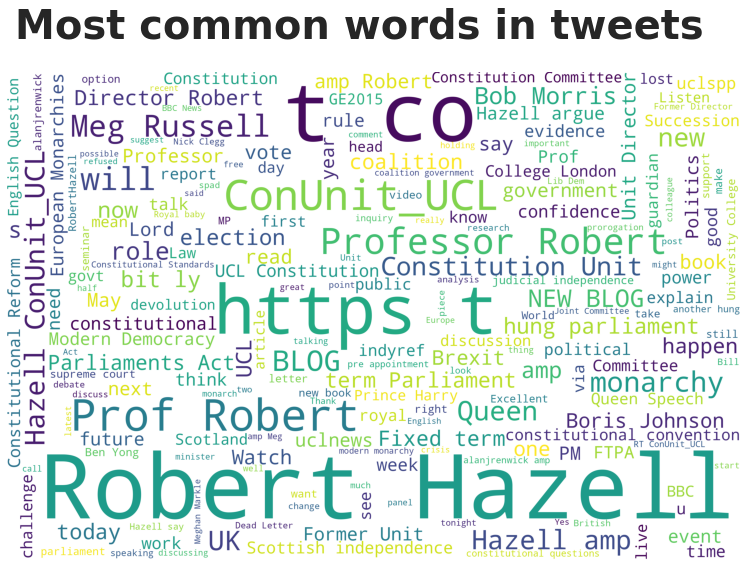

<IPython.core.display.Javascript object>

In [26]:
fig, ax = ser_to_fig_wordcloud(
    df.content, random_state=RANDOM_STATE, title="Most common words in tweets"
)
fig.show()

### Network

In [161]:
import importlib

<IPython.core.display.Javascript object>

In [168]:
from comms_helper.visualisation import network as netvis

<IPython.core.display.Javascript object>

In [169]:
importlib.reload(netvis)

<module 'comms_helper.visualisation.network' from '/usr/local/lib/python3.8/site-packages/comms_helper/visualisation/network.py'>

<IPython.core.display.Javascript object>

In [170]:
import random

random.seed(42)

layout = myg.layout("fr")
edgelist = get_edgelist(myg)

# layout = g_pruned.layout("fr")
# edgelist = get_edgelist(g_pruned)

<IPython.core.display.Javascript object>

In [171]:
# visualiser
visualiser = netvis.NetworkVisualiser(myg, layout, edgelist)


visualiser.get_nodes()

visualiser.get_edges()

visualiser.get_node_colors()

visualiser.get_node_sizes()

<IPython.core.display.Javascript object>

In [173]:
graph_fig = visualiser.visualise_network()

<IPython.core.display.Javascript object>

In [174]:
graph_fig.show()

<IPython.core.display.Javascript object>